## ga_sim

This jn is intended to create simulations of dwarf galaxies and globular clusters using as field stars the catalog of DES. These simulations will be later copied to gawa jn, a pipeline to detect stellar systems and fields stars in the same catalog. In principle, this pipeline read a table in data base with g and r (or bluer and redder) magnitudes, correct the stars for extinction in each band, and randomize its positions in RA and DEC. This is done to avoid stellar systems in the region simulated (and later inspected by the code of detection). The star clusters are inserted later, centered in each HP pixel with specific nside.

All the parameters are smarized in a JSON file in the same folder as this notebook.

To complete all the steps you just have to run all the cells below in sequence.

Firstly, follow the instructions in the README file to install an enviroment with the packages (using terminal). Do it only once.

Following, activate the env in the terminal. In the notebook, restart the kernel and select the env created. Now, you are able to properly run the cells bellow.

Run this jupyter notebook in the LIneA env with the following command:
<br>
`jupyter nbconvert --execute --to html --EmbedImagesPreprocessor.embed_images=True ga_sim.ipynb`
<br>
and after the command has finished, run the following cell:
<br>
`cp ga_sim.html ~/public_html/gawa_processes/NNNNN/simulations/`
<br>
where NNNNN is the process number.

In [1]:
import numpy as np
from astropy.coordinates import SkyCoord
from astropy import units as u
import healpy as hp
import astropy.io.fits as fits
from astropy.table import Table
from astropy.io.fits import getdata
import sqlalchemy
import json
from pathlib import Path
import os
import sys
import glob
import parsl
from parsl.app.app import python_app, bash_app
from parsl.configs.local_threads import config
from time import sleep
from tqdm import tqdm
from ga_sim import (
    make_footprint,
    faker,
    join_cat,
    write_sim_clus_features,
    download_iso,
    read_cat,
    gen_clus_file,
    read_error,
    clus_file_results,
    join_cats_clean,
    split_files,
    clean_input_cat,
    clean_input_cat_dist,
    export_results
)

parsl.clear()
parsl.load(config)


Below, load the JSON config file (change any parameter in case you want) and create folders for results.

Load the maps for reddening.

In [2]:
# Main settings:
confg = "ga_sim.json"

# read config file
with open(confg) as fstream:
    param = json.load(fstream)

# Diretório para os resultados
os.system("mkdir -p " + param['results_path'])

# Reading reddening files
hdu_ngp = fits.open("sample_data/SFD_dust_4096_ngp.fits", memmap=True)
ngp = hdu_ngp[0].data

hdu_sgp = fits.open("sample_data/SFD_dust_4096_sgp.fits", memmap=True)
sgp = hdu_sgp[0].data


Downloading the isochrone table with the last improvements from PARSEC.
Printing age and metalicity of isochrone downloaded. Try one more time in case of empty file. Sometimes there are problems with connection.

In [3]:
download_iso(param['padova_version_code'], param['survey'], 0.0152 * (10 ** param['MH_simulation']),
             param['age_simulation'], param['av_simulation'], param['file_iso'])


Checking age and metalicity of the isochrone. 

mean_mass is the average mass in the range of magnitudes. This is important to calculate a useful range of masses and
avoid wast time simulating a large number of low-mass stars that are not visible in the range of magnitudes in simulation.

In [4]:
# Reading [M/H], log_age, mini, g
iso_info = np.loadtxt(param['file_iso'], usecols=(1, 2, 3, 26), unpack=True)
FeH_iso = iso_info[0][0]
logAge_iso = iso_info[1][0]
m_ini_iso = iso_info[2]
g_iso = iso_info[3]

print('[Fe/H]={:.2f}, Age={:.2f} Gyr'.format(FeH_iso, 10**(logAge_iso-9)))

mM_mean = (param['mM_max'] + param['mM_min']) / 2.
print(np.max(m_ini_iso[g_iso + mM_mean < param['mmax']]))
mean_mass = (np.min(m_ini_iso[g_iso + mM_mean < param['mmax']]) +
             np.max(m_ini_iso[g_iso + mM_mean < param['mmax']])) / 2.

print('Mean mass (M_sun): {:.2f}'.format(mean_mass))


[Fe/H]=-2.00, Age=13.00 Gyr
0.78367275
Mean mass (M_sun): 0.78


Creating the footprint map as a flat map. TODO: Use astropy_healpix to improve the ftp map (better sample of data).

In [5]:
hpx_ftp = make_footprint(param['ra_min'], param['ra_max'], param['dec_min'], param['dec_max'],
                         param['nside_ftp'], output_path=param['results_path'])
print(len(hpx_ftp))


442132


Reading the catalog from DB, writing it as a fits file and returning as positions, magnitudes free of extinction (top of Galaxy, in order to agree to the stellar models) and its errors.

The stars are also filtered in by magnitude and color ranges.

Avoid read from the DB many times in the case the same catalog will be used multiple times.

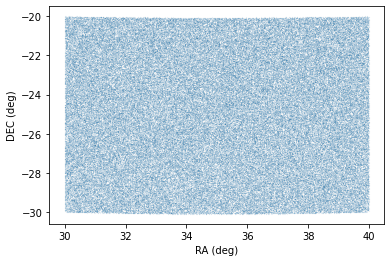

In [6]:
RA, DEC, MAG_G, MAGERR_G, MAG_R, MAGERR_R = read_cat(
    param['vac_ga'], param['ra_min'], param['ra_max'], param['dec_min'], param['dec_max'],
    param['mmin'], param['mmax'], param['cmin'], param['cmax'],
    "DES_Y6_Gold_v1_derred.fits", 1.19863, 0.83734, ngp, sgp, param['results_path'],
    param['results_path'] + "/ftp_4096_nest.fits", param['nside3'], param['nside_ftp'])


## Simulation of dwarf galaxies and globular clusters

In fact, the dwarf galaxies and globular clusters are very similar in terms of stellar populations and stellar density profiles.
Dwarf galaxies have a half-light radius a bit larger than globular clusters (given the amount of dark matter), keeping constant absolute magnitude. The cell below writes the features of a sample of simulated stellar clustesr given the range
of positions, visible masses, distances, exponential radius, ellipticity, positional angle and removing clusters too close to edge of simulated region (border_extract, in degrees). All these pars are read from JSON file.

Generating the properties of clusters based on properties stated above. Writting to file 'objects.dat'.

In [7]:
RA_pix, DEC_pix, r_exp, ell, pa, dist, mass, mM, hp_sample_un = gen_clus_file(
    param['ra_min'],
    param['ra_max'],
    param['dec_min'],
    param['dec_max'],
    param['nside_ini'],
    param['border_extract'],
    param['mM_min'],
    param['mM_max'],
    param['log10_rexp_min'],
    param['log10_rexp_max'],
    param['log10_mass_min'],
    param['log10_mass_max'],
    param['ell_min'],
    param['ell_max'],
    param['pa_min'],
    param['pa_max'],
    param['results_path']
)


## Dist stars
Reading data from magnitude and errors.



In [8]:
mag1_, err1_, err2_ = read_error(param['file_error'], 0.015, 0.015)


Now simulating the clusters.

Code in the cell below simulates stars using a Kroupa or Salpeter as Initial Mass Function (reading initial mass from models). Given the exponential radius, ellipticity and positional angle the stars are distributed into the sky. 

Final table contents the position in sky (RA and DEC), magnitudes + its errors, standard deviation of expected errors and initial masses. 

In [9]:
@python_app
def faker_app(N_stars_cmd, frac_bin, IMF_author, x0, y0, rexp, ell_, pa, dist, hpx, output_path):

    global param

    faker(
        N_stars_cmd,
        frac_bin,
        IMF_author,
        x0,
        y0,
        rexp,
        ell_,
        pa,
        dist,
        hpx,
        param['cmin'],
        param['cmax'],
        param['mmin'],
        param['mmax'],
        mag1_,
        err1_,
        err2_,
        param['file_iso'],
        output_path
    )


# Diretório dos arquivo _clus.dat gerados pela faker.
fake_clus_path = param['results_path'] + '/fake_clus'

futures = list()

# Cria uma Progressbar (Opcional)
with tqdm(total=len(hp_sample_un), file=sys.stdout) as pbar:
    pbar.set_description("Submit Parsls Tasks")

    # Submissão dos Jobs Parsl
    for i in range(len(hp_sample_un)):
        # Estimating the number of stars in cmd dividing mass by mean mass
        N_stars_cmd = int(mass[i] / mean_mass)
        # os.register_at_fork(after_in_child=lambda: _get_font.cache_clear())
        futures.append(
            faker_app(
                N_stars_cmd,
                param['frac_bin'],
                param['IMF_author'],
                RA_pix[i],
                DEC_pix[i],
                r_exp[i],
                ell[i],
                pa[i],
                dist[i],
                hp_sample_un[i],
                output_path=fake_clus_path
            )
        )

        pbar.update()

# Progressbar para acompanhar as parsl.tasks.
print("Tasks Done:")
with tqdm(total=len(futures), file=sys.stdout) as pbar2:
    # is_done é um array contendo True ou False para cada task
    # is_done.count(True) retorna a quantidade de tasks que já terminaram.
    is_done = list()
    done_count = 0
    while is_done.count(True) != len(futures):
        is_done = list()
        for f in futures:
            is_done.append(f.done())

        # Só atualiza a pbar se o valor for diferente.
        if is_done.count(True) != done_count:
            done_count = is_done.count(True)
            # Reset é necessário por que a quantidade de iterações
            # é maior que a quantidade de jobs.
            pbar2.reset(total=len(futures))
            # Atualiza a pbar
            pbar2.update(done_count)

        if done_count < len(futures):
            sleep(3)


Submit Parsls Tasks: 100%|██████████| 66/66 [00:00<00:00, 131.63it/s]
Tasks Done:
100%|██████████| 66/66 [00:00<00:00, 30595.06it/s]


Now, the cell below joins catalogs of simulated clusters and field stars into a single one (optional), and it estimates signal-to-noise ratio from simulations.

In [10]:
mockcat = join_cat(
    param['ra_min'],
    param['ra_max'],
    param['dec_min'],
    param['dec_max'],
    hp_sample_un,
    param['survey'],
    RA,
    DEC,
    MAG_G,
    MAG_R,
    MAGERR_G,
    MAGERR_R,
    param['nside_ini'],
    param['mmax'],
    param['mmin'],
    param['cmin'],
    param['cmax'],
    input_path=fake_clus_path,
    output_path=param['results_path'])


If necessary, split the catalog with simulated clusters and field stars into many files according HP schema.

This is important in case of large catalogs, avoiding create a large single file.

In [11]:
os.makedirs(param['hpx_cats_path'], exist_ok=True)
os.makedirs(param['hpx_cats_clean_path'], exist_ok=True)
ipix_cats = split_files(mockcat, 'ra', 'dec',
                        param['nside_ini'], param['hpx_cats_path'])


## Removing stars in crowded fields

In large surveys, usually objects very close to each other are blended into a single object. In principle, the software used to detect sources is SExtractor, which parameter deblend is set to blend sources very close to each other.

In order to reproduce this observational bias, cells below remove both stars if they are closer than an specific distance.

To do that, the approach below (or the function on that) read catalogs from ipixels (HealPixels).
To each star the distance to all sources are calculated. If the second minimum distance (the first one is zero, since it is the iteration of the stars with itself) is less than the distance defined as a parameter of the function, the star is not listed in the filtered catalog.
The function runs in parallel, in order to run faster using all the cores of node.

Firstly, setting the string to read position of stars. After filtering stars in HealPixels, join all the HP into a single catalog called final cat.

In [ ]:
@python_app
def clean_input_cat_dist_app(dir_name, file_name, ra_str, dec_str, min_dist_arcsec):

    clean_input_cat_dist(
        dir_name,
        file_name,
        ra_str,
        dec_str,
        min_dist_arcsec
    )


futures = list()

# Creating a progreebar
with tqdm(total=len(ipix_cats), file=sys.stdout) as pbar:
    pbar.set_description("Submit Parsls Tasks")

    for i in ipix_cats:
        futures.append(
            clean_input_cat_dist_app(
                param['hpx_cats_clean_path'], i, param['ra_str'], param['dec_str'], param['min_dist_arcsec'])
        )

        pbar.update()

print("Tasks Done:")
with tqdm(total=len(futures), file=sys.stdout) as pbar2:
    # is_done é um array contendo True ou False para cada task
    # is_done.count(True) retorna a quantidade de tasks que já terminaram.
    is_done = list()
    done_count = 0
    while is_done.count(True) != len(futures):
        is_done = list()
        for f in futures:
            is_done.append(f.done())

        # Só atualiza a pbar se o valor for diferente.
        if is_done.count(True) != done_count:
            done_count = is_done.count(True)
            # Reset é necessário por que a quantidade de iterações
            # é maior que a quantidade de jobs.
            pbar2.reset(total=len(futures))
            # Atualiza a pbar
            pbar2.update(done_count)

        if done_count < len(futures):
            sleep(3)


Submit Parsls Tasks: 100%|██████████| 142/142 [00:00<00:00, 244.86it/s]

/home/adriano.pieres/ga_sim/ga_sim/ga_sim.py:601: RuntimeWarning: invalid value encountered in arccos
  dist_ang = np.arccos(costheta)



Tasks Done:
  0%|          | 0/142 [00:00<?, ?it/s]            

In [ ]:
ipix_clean_cats = [i.replace(param['hpx_cats_path'], param['hpx_cats_clean_path']) for i in ipix_cats]

join_cats_clean(ipix_clean_cats,
                param['final_cat'], param['ra_str'], param['dec_str'])


In [ ]:
sim_clus_feat = write_sim_clus_features(
    mockcat, param['final_cat'], hp_sample_un, param['nside_ini'], mM, output_path=param['results_path'])


In [ ]:
clus_file_results(param['results_path'], "star_clusters_simulated.dat",
                  sim_clus_feat, 'results/objects.dat')


## Plots

A few plots to characterize the simulated clusters.

In [ ]:
from ga_sim.plot import (
    general_plots,
    plot_ftp,
    plots_ang_size,
    plots_ref,
    plot_err,
    plot_clusters_clean
)

import tabulate

The cell below show the complete table of the simulated clusters produced. An improved description of columns is provided:
<br>
0-HPX64: Ipix where the cluster is centered (Nested=True, Nside=64);
<br>
1-N: Star counts in cluster (before filtering stars from crowding);
<br>
2-MV: Absolute magnitude in V band (before filtering stars from crowding);
<br>
3-SNR: Poissonian Signal to Noise Ratio of the cluster. This is estimated by star counts within 2 arcmin over
<br>
root square of star counts within an annulus of rin=10 arcmin and rout = 25 arcmin, normalized
<br>
by area. This is calculated before filtering stars from crowding;
<br>
4-N_f: Star counts of filtering in stars by crowding;
<br>
5-MV_f: Absolute magnitude in V band after removing stars by crowding;
<br>
6-SNR_f: Signal to Noise Ratio calculated as described in (3) but after removing stars from crowding;
<br>
7-L: Galactic longitude (l), in degrees;
<br>
8-B: Galactic latitude (b), in degrees;
<br>
9-ra: Right Ascension (Equatorial coordinate), in degrees;
<br>
10-dec: Declination (Equatorial coordinate), in degrees;
<br>
11-r_exp: Exponential radius of cluster, in parsecs;
<br>
12-ell: Ellipticity (a - b) / a;
<br>
13-pa: Angular position (from North to East), in degrees;
<br>
14-mass: Visible mass of cluster (star accounted for mass are stars brighter than the limiting magnitude
<br>
of the simulation), in Solar masses;
<br>
15-dist: distance of the simulated cluster from Sun, in parsecs;

In [ ]:
with open(param['star_clusters_simulated']) as f:
    first_line = f.readline()

table = tabulate.tabulate(np.loadtxt(param['star_clusters_simulated']), tablefmt='html', headers=(first_line[1:].split()))
table

Plot footprint map to check area.

In [ ]:
general_plots(param['star_clusters_simulated'], param['output_plots'])

In [ ]:
# Diretório onde estão os arquivo _clus.dat
plots_ang_size(param['star_clusters_simulated'], param['results_path'],
               param['mmin'], param['mmax'], param['cmin'], param['cmax'],
               param['output_plots'])


In [ ]:
hpx_ftp = param['results_path'] + "/ftp_4096_nest.fits"

plot_ftp(hpx_ftp, param['star_clusters_simulated'],
         param['final_cat'], param['ra_max'], param['ra_min'], param['dec_min'], param['dec_max'], param['output_plots'])


In [ ]:
plots_ref(FeH_iso, param['output_plots'], param['star_clusters_simulated'])


Plotting errors in main magnitude band.

In [ ]:
# Plots to analyze the simulated clusters.
plot_err(mockcat, param['output_plots'])


Plot position of stars in clusters comparing filtered in and not filtered stars. The region sampled is the center of the cluster where the crowding is more intense.

In [ ]:
plot_clusters_clean(ipix_cats, ipix_clean_cats,
                    param['nside_ini'], param['ra_str'], param['dec_str'], 0.01, param['output_plots'])


The images below are the plots comparing simulations and real clusters.

In [ ]:
export_results('../public_html/gawa_processes/')